In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
from astropy.table import Table
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Smooth,Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from sim_engine import F_lam_per_M
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared,Calzetti
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


### Read in Data

In [7]:
def Stack(wv, fl , er):
    
    stwv = [0]
    
    for w in wv:
        if len(w) > len(stwv):
            stwv = w
    
    flxgrid = []
    errgrid = []
    
    for i in range(len(fl)):
        ifl = interp1d(wv[i][~np.isnan(fl[i])], fl[i][~np.isnan(fl[i])], bounds_error=False, fill_value=0)
        ier = interp1d(wv[i][~np.isnan(fl[i])], er[i][~np.isnan(fl[i])], bounds_error=False, fill_value=1E5)
        
        flxgrid.append(ifl(stwv))
        errgrid.append(ier(stwv))
    
    flgrid = np.transpose(flxgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(stwv)])
    for i in range(len(stwv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stwv, stack, err

def get_inner_spec_model(beam, spec2d, fflux, ivar ,rp =1):
    wave, flux, err = beam.beam.trace_extract(spec2d, r=rp,ivar= ivar)

    ok = beam.beam.sensitivity > 0.1*beam.beam.sensitivity.max()

    wave = wave[ok]
    flux  = (flux/fflux)[ok]*beam.beam.scale
    err   = (err/fflux)[ok]

    okerr = np.isfinite(err)
    
    wave = wave[okerr]
    flux = flux[okerr]
    err = err[okerr]
    
    okerr = err < 2*flux
    
    return wave[okerr], flux[okerr], err[okerr]

In [42]:
IWV, IFL, IER = [[],[],[]]
FWV, FFL, FER = [[],[],[]]

for fitsfile in glob('../CLEAR_show_and_tell/2*_12078.g102.A.fits'):
    obeam = model.BeamCutout(fits_file=fitsfile)
    
    flat = obeam.flat_flam.reshape(obeam.beam.sh_beam)
    w, ffl, e = obeam.beam.trace_extract(flat, ivar=obeam.ivar, r=7)
    
    Fw,Ff,Fe = get_inner_spec_model(obeam, obeam.grism.data['SCI'] - obeam.contam, ffl, obeam.ivar, rp=7)
    Iw,If,Ie = get_inner_spec_model(obeam, obeam.grism.data['SCI'] - obeam.contam, ffl, obeam.ivar, rp=3)
    
    if len(Iw) > 2:
        IWV.append(Iw)
        IFL.append(If)    
        IER.append(Ie)  
        
        FWV.append(Fw)
        FFL.append(Ff)    
        FER.append(Fe)  

MWV, MFL, MER = Stack(np.array(FWV),np.array(FFL),np.array(FER))
IWV, IFL, IER = Stack(np.array(IWV),np.array(IFL),np.array(IER))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:656: RuntimeWarning: divide by zero encountered in true_divide
  var = 1./ivar
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/

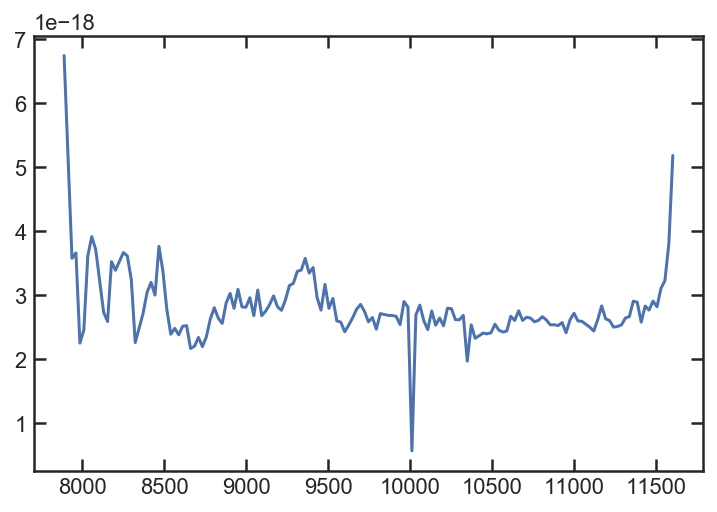

In [43]:
plt.plot(MWV, MFL)

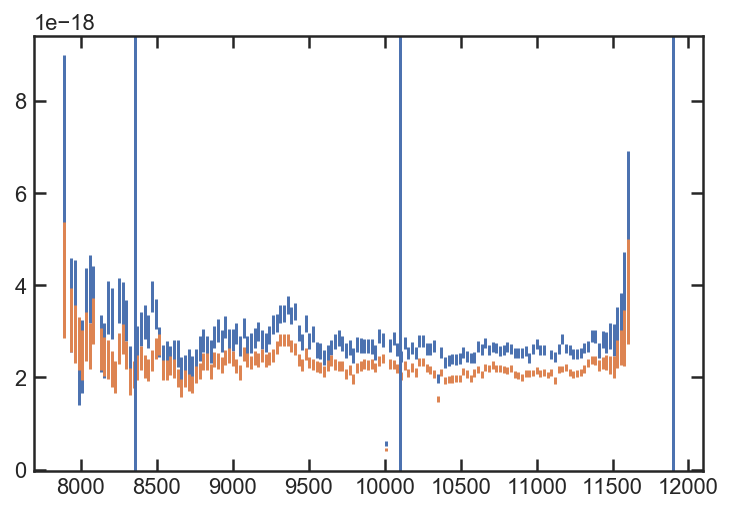

In [44]:
plt.errorbar(MWV, MFL, yerr = MER, linestyle = 'none')
plt.errorbar(IWV, IFL, yerr = IER, linestyle = 'none')

plt.axvline(8357)
plt.axvline(10101)
plt.axvline(11897)

In [45]:
IDX = [U for U in range(len(MWV)) if 8400 < MWV[U] < 11000]

MWV = MWV[IDX]
MFL = MFL[IDX]
MER = MER[IDX]

iIFL = interp1d(IWV,IFL)(MWV)
iIER = interp1d(IWV,IER)(MWV)

scl = np.trapz(MFL, MWV)
scl2 =np.trapz(iIFL, MWV)

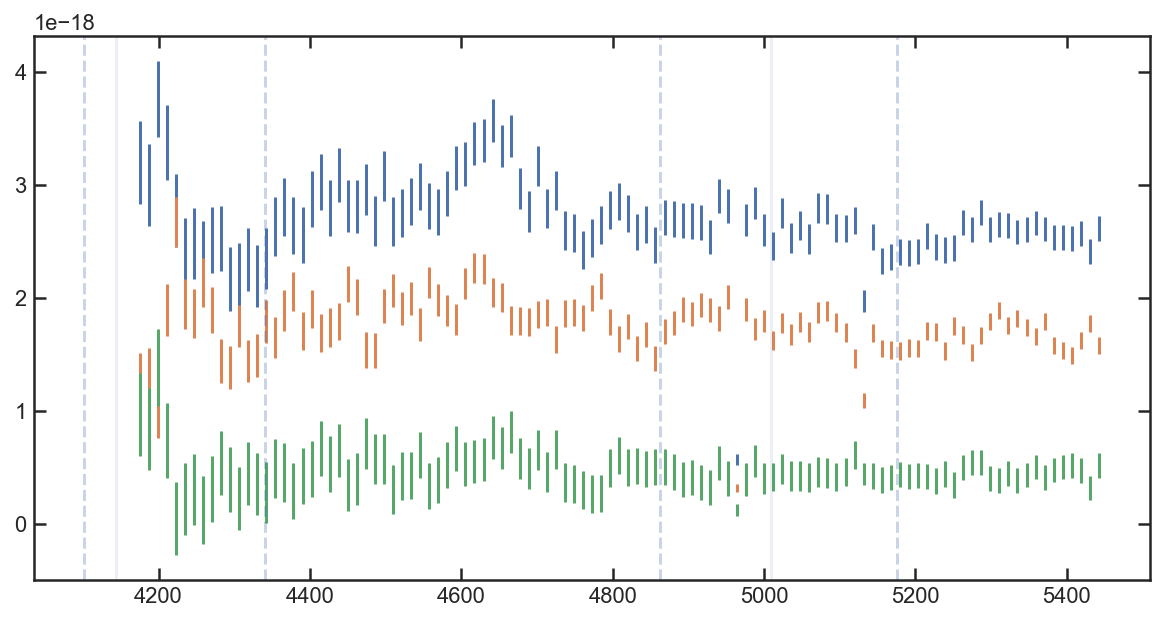

In [55]:
OFL = MFL - iIFL


plt.figure(figsize = [10,5])

plt.errorbar(MWV/(1+1.0167), MFL, MER, linestyle = 'none')

plt.errorbar(MWV/(1+1.0167), iIFL - OFL , iIER, linestyle = 'none')
plt.errorbar(MWV/(1+1.0167), OFL, MER, linestyle = 'none')

plt.axvline(8357/(1+1.0167), alpha = 0.1)
plt.axvline(10101/(1+1.0167), alpha = 0.1)

plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)
plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)

(0, 2)

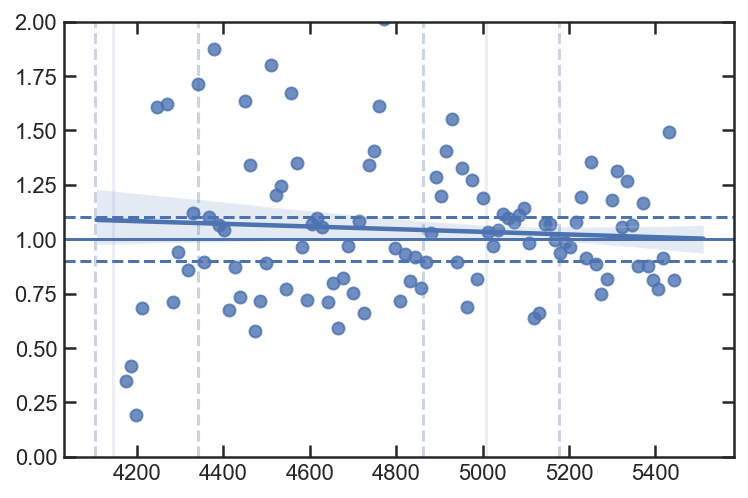

In [57]:
scl = np.trapz(OFL, MWV)
scl2 =np.trapz(iIFL - OFL, MWV)

sea.regplot(MWV/(1+1.0167), (iIFL - OFL)/(OFL) * scl / scl2, robust = True , ci=68)

plt.axhline(1)
plt.axhline(1.1, linestyle = '--')
plt.axhline(0.9, linestyle = '--')


plt.axvline(8357/(1+1.0167), alpha = 0.1)
plt.axvline(10101/(1+1.0167), alpha = 0.1)

plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)
plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)

plt.ylim(0,2)

<ErrorbarContainer object of 3 artists>

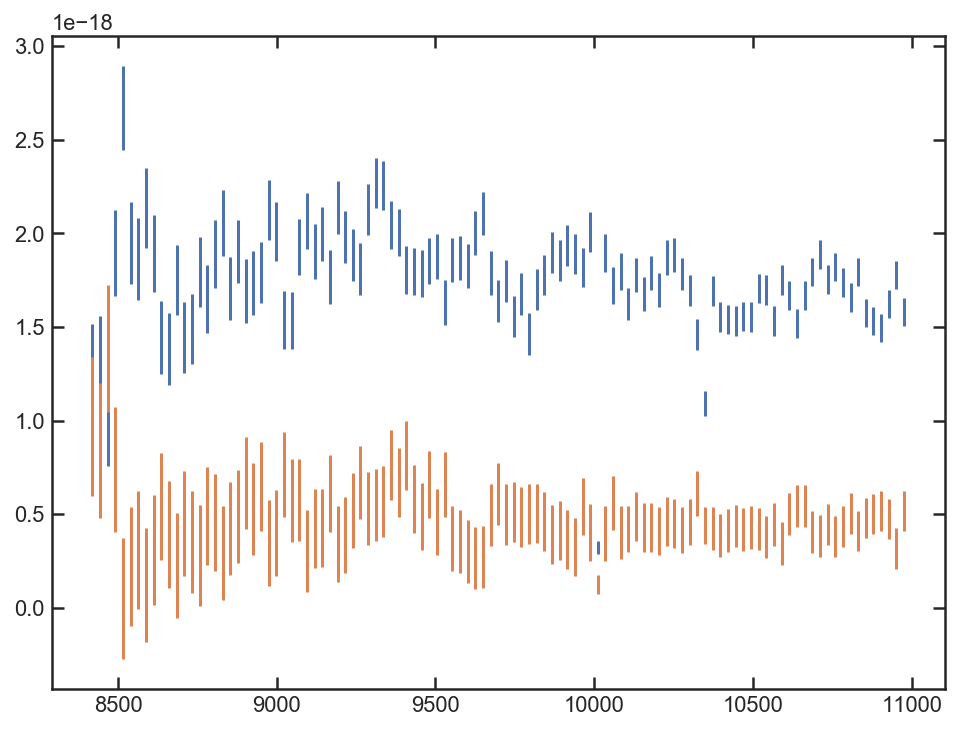

In [52]:
OFL = MFL - iIFL

# plt.figure(figsize=[8,6])
# plt.errorbar(MWV, MFL, MER, linestyle = 'none')

plt.figure(figsize=[8,6])
plt.errorbar(MWV, iIFL-OFL, iIER, linestyle = 'none')

# plt.figure(figsize=[8,6])
plt.errorbar(MWV, OFL, MER, linestyle = 'none')


In [58]:
IWV, IFL, IER = [[],[],[]]
FWV, FFL, FER = [[],[],[]]

for fitsfile in glob('../CLEAR_show_and_tell/*_39170.g102.A.fits'):
    obeam = model.BeamCutout(fits_file=fitsfile)
    
    flat = obeam.flat_flam.reshape(obeam.beam.sh_beam)
    w, ffl, e = obeam.beam.trace_extract(flat, ivar=obeam.ivar, r=7)
    
    Fw,Ff,Fe = get_inner_spec_model(obeam, obeam.grism.data['SCI'] - obeam.contam, ffl, obeam.ivar, rp=7)
    Iw,If,Ie = get_inner_spec_model(obeam, obeam.grism.data['SCI'] - obeam.contam, ffl, obeam.ivar, rp=3)
    
    if len(Iw) > 2:
        IWV.append(Iw)
        IFL.append(If)    
        IER.append(Ie)  
        
        FWV.append(Fw)
        FFL.append(Ff)    
        FER.append(Fe)  

MWV, MFL, MER = Stack(np.array(FWV),np.array(FFL),np.array(FER))
IWV, IFL, IER = Stack(np.array(IWV),np.array(IFL),np.array(IER))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:656: RuntimeWarning: divide by zero encountered in true_divide
  var = 1./ivar
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/

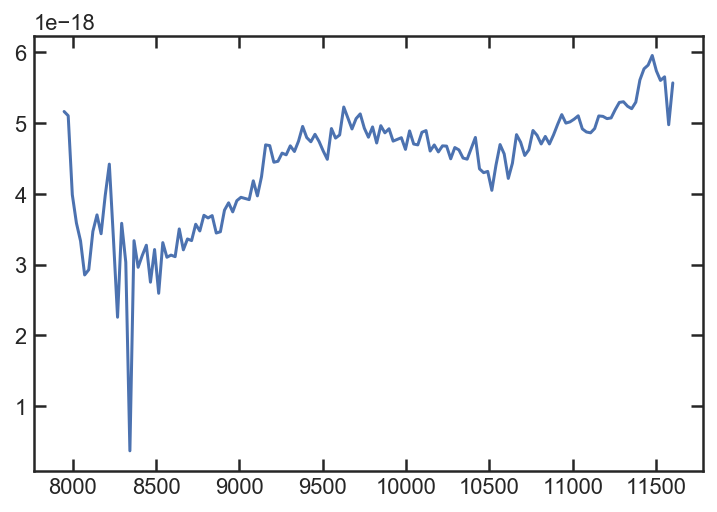

In [59]:
plt.plot(MWV, MFL)

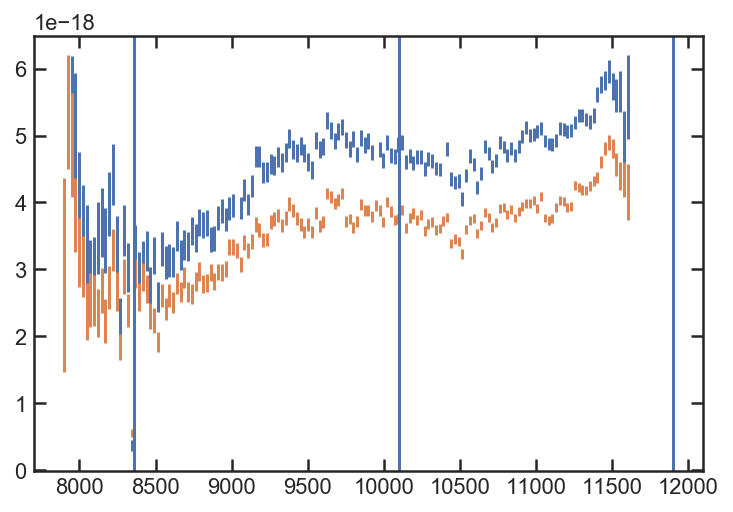

In [60]:
plt.errorbar(MWV, MFL, yerr = MER, linestyle = 'none')
plt.errorbar(IWV, IFL, yerr = IER, linestyle = 'none')

plt.axvline(8357)
plt.axvline(10101)
plt.axvline(11897)

In [61]:
IDX = [U for U in range(len(MWV)) if 8400 < MWV[U] < 11000]

MWV = MWV[IDX]
MFL = MFL[IDX]
MER = MER[IDX]

iIFL = interp1d(IWV,IFL)(MWV)
iIER = interp1d(IWV,IER)(MWV)

scl = np.trapz(MFL, MWV)
scl2 =np.trapz(iIFL, MWV)

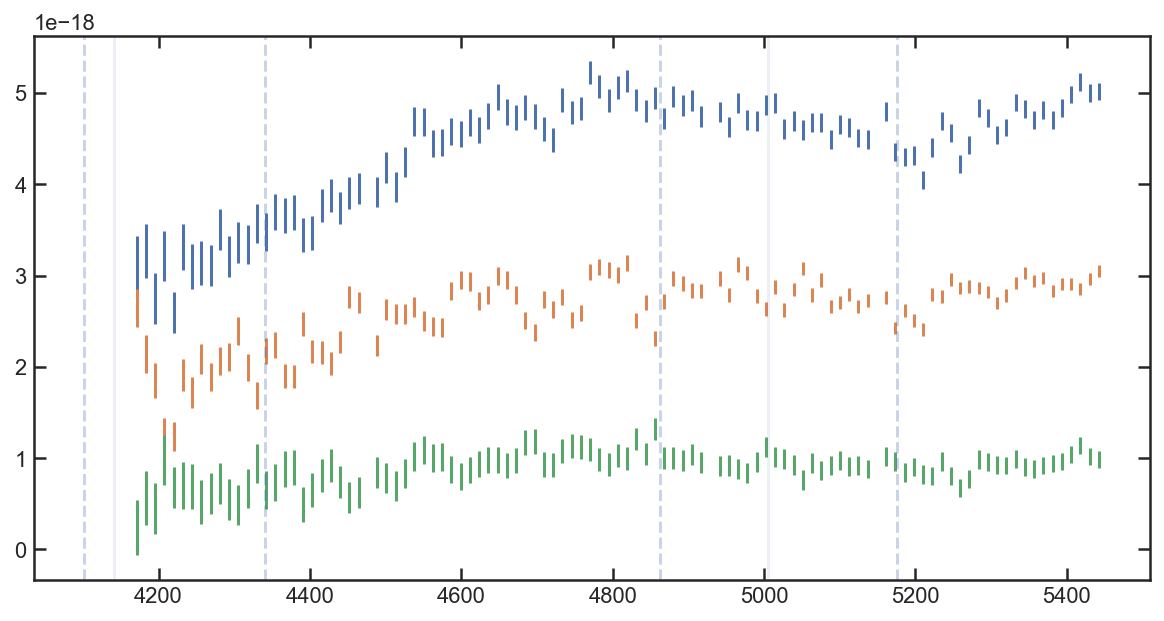

In [62]:
OFL = MFL - iIFL


plt.figure(figsize = [10,5])

plt.errorbar(MWV/(1+1.018), MFL, MER, linestyle = 'none')

plt.errorbar(MWV/(1+1.018), iIFL - OFL , iIER, linestyle = 'none')
plt.errorbar(MWV/(1+1.018), OFL, MER, linestyle = 'none')

plt.axvline(8357/(1+1.018), alpha = 0.1)
plt.axvline(10101/(1+1.018), alpha = 0.1)

plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)
plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)

(0, 2)

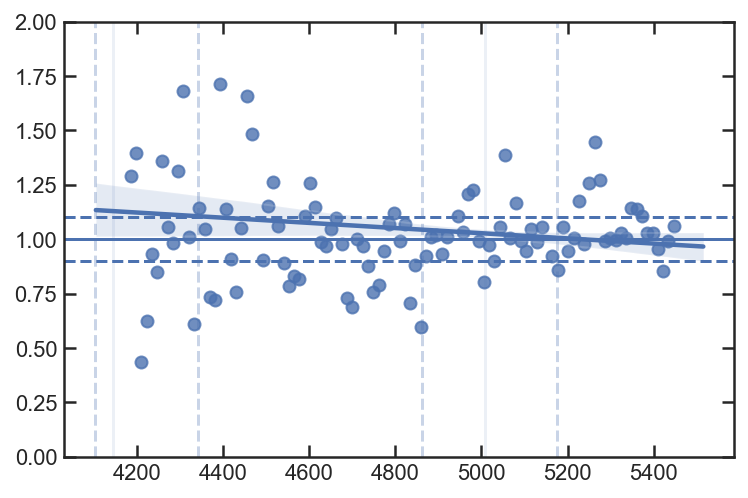

In [70]:
scl = np.trapz(OFL, MWV)
scl2 =np.trapz(iIFL - OFL, MWV)

sea.regplot(MWV/(1+1.0167), (iIFL - OFL)/(OFL) * scl / scl2, order = 1 , ci=68)

plt.axhline(1)
plt.axhline(1.1, linestyle = '--')
plt.axhline(0.9, linestyle = '--')


plt.axvline(8357/(1+1.0167), alpha = 0.1)
plt.axvline(10101/(1+1.0167), alpha = 0.1)

plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)
plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)

plt.ylim(0,2)

<ErrorbarContainer object of 3 artists>

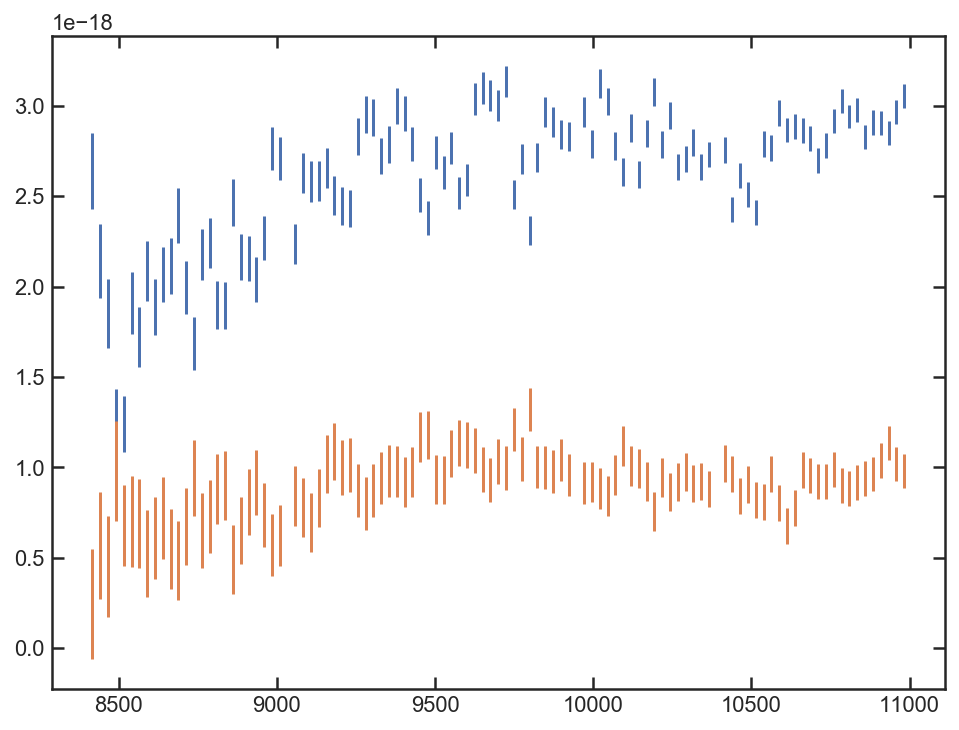

In [72]:
plt.figure(figsize=[8,6])
plt.errorbar(MWV, iIFL - OFL, iIER, linestyle = 'none')

plt.errorbar(MWV, OFL, MER, linestyle = 'none')